In [5]:
# Cell 1: Complete Setup with Inline Model Definitions
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
import torchvision.models as models
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# Import data modules
from src.data.dataset import ChestXrayDataset, create_data_splits, calculate_class_weights
from src.data.dataloader import create_rtx3060_dataloaders

# Define DenseNet121 Model Inline
class DenseNet121MultiLabel(nn.Module):
    """DenseNet121 for multi-label chest X-ray classification"""
    
    def __init__(self, num_classes=15, pretrained=True, dropout_rate=0.3):
        super().__init__()
        
        self.num_classes = num_classes
        
        # Load pretrained DenseNet121
        self.backbone = models.densenet121(pretrained=pretrained)
        
        # Get number of features from classifier
        num_features = self.backbone.classifier.in_features  # 1024
        
        # Replace classifier with custom multi-label head
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(512, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
        
        print(f"✅ DenseNet121 Multi-Label Model created:")
        print(f"   Classes: {num_classes}")
        print(f"   Pretrained: {pretrained}")
        print(f"   Dropout: {dropout_rate}")
    
    def _initialize_weights(self):
        """Initialize classifier weights with Xavier normal"""
        for module in self.backbone.classifier.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        """Forward pass - returns logits"""
        return self.backbone(x)
    
    def predict_probabilities(self, x):
        """Get class probabilities using sigmoid"""
        logits = self.forward(x)
        return torch.sigmoid(logits)

# Define Loss Functions Inline
class CombinedLoss(nn.Module):
    """Combined Weighted BCE + Focal Loss for extreme class imbalance"""
    
    def __init__(self, class_weights=None, focal_alpha=0.25, focal_gamma=2.0, 
                 focal_weight=0.4, bce_weight=0.6):
        super().__init__()
        
        self.class_weights = class_weights
        self.focal_alpha = focal_alpha
        self.focal_gamma = focal_gamma
        self.focal_weight = focal_weight
        self.bce_weight = bce_weight
        
        print(f"✅ Combined Loss: BCE({bce_weight}) + Focal({focal_weight})")
        
    def forward(self, logits, targets):
        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)
        probs = torch.clamp(probs, min=1e-7, max=1-1e-7)
        
        # Weighted BCE Loss
        bce = -(targets * torch.log(probs) + (1 - targets) * torch.log(1 - probs))
        if self.class_weights is not None:
            if self.class_weights.device != bce.device:
                self.class_weights = self.class_weights.to(bce.device)
            bce = bce * self.class_weights.unsqueeze(0)
        bce_loss = bce.mean()
        
        # Focal Loss
        pos_loss = -self.focal_alpha * (1 - probs) ** self.focal_gamma * targets * torch.log(probs)
        neg_loss = -(1 - self.focal_alpha) * probs ** self.focal_gamma * (1 - targets) * torch.log(1 - probs)
        focal_loss = (pos_loss + neg_loss).mean()
        
        # Combine losses
        combined = self.focal_weight * focal_loss + self.bce_weight * bce_loss
        return combined

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"   CUDA version: {torch.version.cuda}")

print("\n✅ All models and functions defined inline - ready to proceed!")

🚀 Using device: cuda
   GPU: NVIDIA GeForce RTX 3060
   VRAM: 12.9 GB
   CUDA version: 11.8

✅ All models and functions defined inline - ready to proceed!


In [6]:
# Cell 2: Load Data Pipeline
BASE_PATH = Path(r"D:/Projects/CLARITY/Model/Dataset/archive")

print("🔄 Loading data pipeline...")

# Load metadata
data_entry_path = BASE_PATH / "Data_Entry_2017.csv"
df = pd.read_csv(data_entry_path)
print(f"✅ Metadata loaded: {len(df):,} entries")

# Recreate image mapping
image_mapping = {}
for main_folder in sorted(BASE_PATH.iterdir()):
    if main_folder.is_dir() and main_folder.name.startswith('images_'):
        images_subfolder = main_folder / 'images'
        if images_subfolder.exists():
            for img_file in images_subfolder.glob("*.png"):
                image_name = img_file.name
                if image_name not in image_mapping:
                    image_mapping[image_name] = img_file

print(f"✅ Image mapping created: {len(image_mapping):,} images")
print(f"✅ Dataset completeness: {len(image_mapping)/len(df)*100:.1f}%")

🔄 Loading data pipeline...
✅ Metadata loaded: 112,120 entries
✅ Image mapping created: 112,120 images
✅ Dataset completeness: 100.0%


In [7]:
# Cell 3: Create Data Splits
print("🔄 Creating data splits...")

train_df, val_df, test_df = create_data_splits(df, 
                                               test_size=0.15,
                                               val_size=0.10,
                                               random_seed=42)

print(f"✅ Data splits created successfully")

🔄 Creating data splits...
Patient-level data splits:
  Train: 83,847 images from 23,105 patients (74.8%)
  Val:   11,550 images from 3,080 patients (10.3%)
  Test:  16,723 images from 4,620 patients (14.9%)
✅ No patient overlap verified - clean splits!
✅ Data splits created successfully


In [8]:
# Cell 4: Create Datasets
print("🔄 Creating datasets...")

train_dataset = ChestXrayDataset(
    df=train_df,
    image_mapping=image_mapping,
    image_size=384,  # Optimized for RTX 3060
    is_training=True,
    augmentation_prob=0.8
)

val_dataset = ChestXrayDataset(
    df=val_df,
    image_mapping=image_mapping,
    image_size=384,
    is_training=False
)

test_dataset = ChestXrayDataset(
    df=test_df,
    image_mapping=image_mapping,
    image_size=384,
    is_training=False
)

print(f"✅ Datasets created successfully!")

🔄 Creating datasets...
Dataset created with 83847 samples
Training mode: True
Image size: 384x384

Label matrix created: (83847, 15)
Positive samples per class:
  No Finding...............  45146
  Atelectasis..............   8720
  Cardiomegaly.............   2019
  Effusion.................  10071
  Infiltration.............  14772
  Mass.....................   4477
  Nodule...................   4691
  Pneumonia................   1062
  Pneumothorax.............   3981
  Consolidation............   3458
  Edema....................   1738
  Emphysema................   1794
  Fibrosis.................   1236
  Pleural_Thickening.......   2562
  Hernia...................    171
Transforms created for training
Dataset created with 11550 samples
Training mode: False
Image size: 384x384

Label matrix created: (11550, 15)
Positive samples per class:
  No Finding...............   6197
  Atelectasis..............   1148
  Cardiomegaly.............    331
  Effusion.................   1311
  I

In [9]:
# Cell 5: Calculate Class Weights and Create DataLoaders
print("🔄 Calculating class weights...")
class_weights = calculate_class_weights(train_dataset.labels, method='inverse_freq')

print("🔄 Creating optimized dataloaders...")
train_loader, val_loader, test_loader = create_rtx3060_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    batch_size=16,  # Optimized for 384px images
    num_workers=4,
    use_weighted_sampling=True
)

print(f"✅ DataLoaders created successfully!")

🔄 Calculating class weights...

Class weights (inverse_freq):
--------------------------------------------------
No Finding...............    0.031 (pos:  45146)
Atelectasis..............    0.158 (pos:   8720)
Cardiomegaly.............    0.684 (pos:   2019)
Effusion.................    0.137 (pos:  10071)
Infiltration.............    0.093 (pos:  14772)
Mass.....................    0.308 (pos:   4477)
Nodule...................    0.294 (pos:   4691)
Pneumonia................    1.299 (pos:   1062)
Pneumothorax.............    0.347 (pos:   3981)
Consolidation............    0.399 (pos:   3458)
Edema....................    0.794 (pos:   1738)
Emphysema................    0.769 (pos:   1794)
Fibrosis.................    1.116 (pos:   1236)
Pleural_Thickening.......    0.539 (pos:   2562)
Hernia...................    8.030 (pos:    171)
🔄 Creating optimized dataloaders...
Creating RTX 3060 optimized dataloaders:
  Batch size: 16
  Num workers: 4
  Weighted sampling: True
  Weighted samp

In [10]:
# Cell 6: Create Model and Start Training
print("🔄 Creating DenseNet121 model...")

# Create model
model = DenseNet121MultiLabel(
    num_classes=15,
    pretrained=True,
    dropout_rate=0.3
).to(device)

# Create loss function
criterion = CombinedLoss(
    class_weights=class_weights,
    focal_weight=0.4,
    bce_weight=0.6
).to(device)

# Create optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.1f} MB")

print(f"\n🚀 Ready to start training!")

🔄 Creating DenseNet121 model...
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


100%|█████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:03<00:00, 10.1MB/s]


✅ DenseNet121 Multi-Label Model created:
   Classes: 15
   Pretrained: True
   Dropout: 0.3
✅ Combined Loss: BCE(0.6) + Focal(0.4)

📊 Model Statistics:
   Total parameters: 7,487,375
   Trainable parameters: 7,487,375
   Model size: ~29.9 MB

🚀 Ready to start training!


In [11]:
# Cell 6: Create Model and Start Training
print("🔄 Creating DenseNet121 model...")

# Create model
model = DenseNet121MultiLabel(
    num_classes=15,
    pretrained=True,
    dropout_rate=0.3
).to(device)

# Create loss function
criterion = CombinedLoss(
    class_weights=class_weights,
    focal_weight=0.4,
    bce_weight=0.6
).to(device)

# Create optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.1f} MB")

print(f"\n🚀 Ready to start training!")

🔄 Creating DenseNet121 model...
✅ DenseNet121 Multi-Label Model created:
   Classes: 15
   Pretrained: True
   Dropout: 0.3
✅ Combined Loss: BCE(0.6) + Focal(0.4)

📊 Model Statistics:
   Total parameters: 7,487,375
   Trainable parameters: 7,487,375
   Model size: ~29.9 MB

🚀 Ready to start training!


In [12]:
# Cell 7: Simple Training Loop
print("🚀 Starting CLARITy model training...")
print("=" * 80)

# Training parameters
num_epochs = 20  # Start with fewer epochs
scaler = GradScaler()  # Mixed precision

train_losses = []
val_losses = []
val_aucs = []
best_val_auc = 0.0

for epoch in range(1, num_epochs + 1):
    # Training
    model.train()
    train_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")
    for batch_idx, (images, labels, metadata) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            logits = model(images)
            loss = criterion(logits, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        # Memory cleanup
        if batch_idx % 50 == 0:
            torch.cuda.empty_cache()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, metadata in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            with autocast():
                logits = model(images)
                loss = criterion(logits, labels)
            
            val_loss += loss.item()
            
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Calculate AUC
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    
    aucs = []
    for i in range(15):
        if all_labels[:, i].sum() > 0:
            auc = roc_auc_score(all_labels[:, i], all_probs[:, i])
            aucs.append(auc)
    
    val_auc = np.mean(aucs)
    val_aucs.append(val_auc)
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"💾 New best model saved: AUC = {best_val_auc:.4f}")
    
    print(f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}")

print(f"\n🎉 Training completed!")
print(f"Best validation AUC: {best_val_auc:.4f}")

🚀 Starting CLARITy model training...


Epoch 1/20: 100%|█████████████████████████████████████████████████████| 5240/5240 [14:28<00:00,  6.03it/s, Loss=0.2095]


💾 New best model saved: AUC = 0.5757
Epoch  1 | Train Loss: nan | Val Loss: inf | Val AUC: 0.5757


Epoch 2/20: 100%|█████████████████████████████████████████████████████| 5240/5240 [14:32<00:00,  6.01it/s, Loss=0.1777]


Epoch  2 | Train Loss: 0.2071 | Val Loss: 0.2095 | Val AUC: 0.5179


Epoch 3/20: 100%|█████████████████████████████████████████████████████| 5240/5240 [14:21<00:00,  6.08it/s, Loss=0.1252]


Epoch  3 | Train Loss: 0.1977 | Val Loss: 0.1768 | Val AUC: 0.5570


Epoch 4/20: 100%|█████████████████████████████████████████████████████| 5240/5240 [14:21<00:00,  6.08it/s, Loss=0.2174]


Epoch  4 | Train Loss: 0.1945 | Val Loss: 0.0994 | Val AUC: 0.5091


Epoch 5/20: 100%|█████████████████████████████████████████████████████| 5240/5240 [14:14<00:00,  6.13it/s, Loss=0.2908]


Epoch  5 | Train Loss: 0.1884 | Val Loss: 0.3445 | Val AUC: 0.5588


Epoch 6/20: 100%|█████████████████████████████████████████████████████| 5240/5240 [14:40<00:00,  5.95it/s, Loss=0.2635]


💾 New best model saved: AUC = 0.6263
Epoch  6 | Train Loss: 0.1826 | Val Loss: 0.1339 | Val AUC: 0.6263


Epoch 7/20: 100%|█████████████████████████████████████████████████████| 5240/5240 [14:43<00:00,  5.93it/s, Loss=0.1461]


💾 New best model saved: AUC = 0.6543
Epoch  7 | Train Loss: 0.1779 | Val Loss: 0.1063 | Val AUC: 0.6543


Epoch 8/20: 100%|█████████████████████████████████████████████████████| 5240/5240 [14:17<00:00,  6.11it/s, Loss=0.2758]


Epoch  8 | Train Loss: 0.1715 | Val Loss: 0.0951 | Val AUC: 0.6474


Epoch 9/20: 100%|█████████████████████████████████████████████████████| 5240/5240 [14:22<00:00,  6.07it/s, Loss=0.1922]


Epoch  9 | Train Loss: 0.1644 | Val Loss: 0.1275 | Val AUC: 0.6514


Epoch 10/20: 100%|████████████████████████████████████████████████████| 5240/5240 [14:22<00:00,  6.07it/s, Loss=0.1275]


💾 New best model saved: AUC = 0.6616
Epoch 10 | Train Loss: 0.1573 | Val Loss: 0.0914 | Val AUC: 0.6616


Epoch 11/20: 100%|████████████████████████████████████████████████████| 5240/5240 [14:23<00:00,  6.07it/s, Loss=0.1534]


Epoch 11 | Train Loss: 0.1491 | Val Loss: 0.1571 | Val AUC: 0.6564


Epoch 12/20: 100%|████████████████████████████████████████████████████| 5240/5240 [14:10<00:00,  6.16it/s, Loss=0.1504]


💾 New best model saved: AUC = 0.6745
Epoch 12 | Train Loss: 0.1424 | Val Loss: 0.1074 | Val AUC: 0.6745


Epoch 13/20: 100%|████████████████████████████████████████████████████| 5240/5240 [14:35<00:00,  5.99it/s, Loss=0.1439]


💾 New best model saved: AUC = 0.6746
Epoch 13 | Train Loss: 0.1357 | Val Loss: 0.0861 | Val AUC: 0.6746


Epoch 14/20: 100%|████████████████████████████████████████████████████| 5240/5240 [14:45<00:00,  5.92it/s, Loss=0.0924]


Epoch 14 | Train Loss: 0.1309 | Val Loss: 0.0943 | Val AUC: 0.6723


Epoch 15/20: 100%|████████████████████████████████████████████████████| 5240/5240 [14:19<00:00,  6.09it/s, Loss=0.1226]


💾 New best model saved: AUC = 0.6777
Epoch 15 | Train Loss: 0.1258 | Val Loss: 0.0785 | Val AUC: 0.6777


Epoch 16/20: 100%|████████████████████████████████████████████████████| 5240/5240 [14:49<00:00,  5.89it/s, Loss=0.1312]


Epoch 16 | Train Loss: 0.1223 | Val Loss: 0.0794 | Val AUC: 0.6738


Epoch 17/20: 100%|████████████████████████████████████████████████████| 5240/5240 [14:15<00:00,  6.12it/s, Loss=0.1516]


💾 New best model saved: AUC = 0.6897
Epoch 17 | Train Loss: 0.1186 | Val Loss: 0.0787 | Val AUC: 0.6897


Epoch 18/20: 100%|████████████████████████████████████████████████████| 5240/5240 [13:53<00:00,  6.29it/s, Loss=0.0925]


Epoch 18 | Train Loss: 0.1166 | Val Loss: 0.0794 | Val AUC: 0.6871


Epoch 19/20: 100%|████████████████████████████████████████████████████| 5240/5240 [13:55<00:00,  6.27it/s, Loss=0.1045]


Epoch 19 | Train Loss: nan | Val Loss: 0.0729 | Val AUC: 0.6889


Epoch 20/20: 100%|████████████████████████████████████████████████████| 5240/5240 [14:05<00:00,  6.20it/s, Loss=0.1146]


💾 New best model saved: AUC = 0.6914
Epoch 20 | Train Loss: nan | Val Loss: 0.0962 | Val AUC: 0.6914

🎉 Training completed!
Best validation AUC: 0.6914


In [13]:
# Quick Model Testing and Saving
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report
from datetime import datetime

print("🧪 Testing trained model...")

# 1. SAVE MODEL
model_name = f"CLARITy_DenseNet121_{datetime.now().strftime('%Y%m%d_%H%M')}.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_auc': best_val_auc,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_aucs': val_aucs,
    'model_info': {
        'num_classes': 15,
        'image_size': 384,
        'architecture': 'DenseNet121'
    }
}, model_name)
print(f"💾 Model saved as: {model_name}")

# 2. QUICK TEST ON TEST SET
model.eval()
test_predictions = []
test_labels = []
test_losses = []

print("🔍 Running test evaluation...")
with torch.no_grad():
    for i, (images, labels, metadata) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        
        logits = model(images)
        probs = torch.sigmoid(logits)
        
        # Store for metrics
        test_predictions.append(probs.cpu().numpy())
        test_labels.append(labels.cpu().numpy())
        
        # Calculate loss
        loss = criterion(logits, labels)
        test_losses.append(loss.item())
        
        if i % 100 == 0:
            print(f"  Processed {i+1}/{len(test_loader)} batches")

# 3. CALCULATE TEST METRICS
test_predictions = np.concatenate(test_predictions)
test_labels = np.concatenate(test_labels)
test_loss = np.mean(test_losses)

# Per-class AUC
disease_classes = [
    'No Finding', 'Atelectasis', 'Cardiomegaly', 'Effusion', 
    'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
    'Pleural_Thickening', 'Hernia'
]

print(f"\n🎯 TEST RESULTS:")
print(f"=" * 50)
print(f"Test Loss: {test_loss:.4f}")

test_aucs = []
for i, disease in enumerate(disease_classes):
    if test_labels[:, i].sum() > 0:
        auc = roc_auc_score(test_labels[:, i], test_predictions[:, i])
        test_aucs.append(auc)
        print(f"{disease:.<25} AUC: {auc:.3f}")
    else:
        test_aucs.append(0.0)
        print(f"{disease:.<25} AUC: N/A (no positive samples)")

mean_test_auc = np.mean([auc for auc in test_aucs if auc > 0])
print(f"=" * 50)
print(f"Mean Test AUC: {mean_test_auc:.4f}")

# 4. SAVE PREDICTIONS
np.save('test_predictions.npy', test_predictions)
np.save('test_labels.npy', test_labels)
print(f"💾 Test predictions saved to test_predictions.npy")

# 5. FINAL SUMMARY
print(f"\n🏆 CLARITY MODEL SUMMARY:")
print(f"=" * 60)
print(f"Training completed: ✅")
print(f"Best validation AUC: {best_val_auc:.4f}")
print(f"Final test AUC: {mean_test_auc:.4f}")
print(f"Model saved as: {model_name}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Training epochs: {len(train_losses)}")

🧪 Testing trained model...
💾 Model saved as: CLARITy_DenseNet121_20251004_0139.pth
🔍 Running test evaluation...
  Processed 1/1046 batches
  Processed 101/1046 batches
  Processed 201/1046 batches
  Processed 301/1046 batches
  Processed 401/1046 batches
  Processed 501/1046 batches
  Processed 601/1046 batches
  Processed 701/1046 batches
  Processed 801/1046 batches
  Processed 901/1046 batches
  Processed 1001/1046 batches

🎯 TEST RESULTS:
Test Loss: 0.1006
No Finding............... AUC: 0.670
Atelectasis.............. AUC: 0.695
Cardiomegaly............. AUC: 0.789
Effusion................. AUC: 0.762
Infiltration............. AUC: 0.633
Mass..................... AUC: 0.605
Nodule................... AUC: 0.564
Pneumonia................ AUC: 0.645
Pneumothorax............. AUC: 0.699
Consolidation............ AUC: 0.736
Edema.................... AUC: 0.828
Emphysema................ AUC: 0.648
Fibrosis................. AUC: 0.641
Pleural_Thickening....... AUC: 0.662
Hernia...........

In [17]:
# Fixed Model Saving and Loading
import torch
from pathlib import Path
from datetime import datetime

# Create proper directory structure
model_dir = Path("../models/saved_models")
checkpoint_dir = Path("../models/checkpoints")
model_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir.mkdir(parents=True, exist_ok=True)

print("📁 Created model directories")

# Standard model save format
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f"densenet121.pth"
model_path = model_dir / model_filename

# Save complete model state (FIXED)
torch.save({
    # Model architecture info
    'model_name': 'CLARITy_DenseNet121',
    'architecture': 'DenseNet121',
    'num_classes': 15,
    'image_size': 384,
    'pretrained': True,
    'dropout_rate': 0.3,
    
    # Model weights
    'model_state_dict': model.state_dict(),
    
    # Training metrics (convert to Python types)
    'best_val_auc': float(best_val_auc),
    'final_train_loss': float(train_losses[-1]) if train_losses else 0.0,
    'final_val_loss': float(val_losses[-1]) if val_losses else 0.0,
    'total_epochs': int(len(train_losses)),
    
    # Convert numpy arrays to lists
    'train_losses': [float(x) for x in train_losses],
    'val_losses': [float(x) for x in val_losses], 
    'val_aucs': [float(x) for x in val_aucs],
    
    # Dataset info
    'dataset_info': {
        'total_images': int(len(df)),
        'train_size': int(len(train_dataset)),
        'val_size': int(len(val_dataset)),
        'test_size': int(len(test_dataset))
    },
    
    # Save timestamp
    'saved_at': timestamp,
    'pytorch_version': torch.__version__
    
}, model_path)

print(f"✅ Model saved: {model_path}")

# Fixed loading function
def load_clarity_model(model_path, device='cuda'):
    """Load CLARITy model with proper weights_only handling"""
    
    # Load with weights_only=False for full checkpoint
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Recreate model
    model = DenseNet121MultiLabel(
        num_classes=checkpoint['num_classes'],
        pretrained=False,
        dropout_rate=checkpoint['dropout_rate']
    )
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    return model, checkpoint

# Test loading (FIXED)
print("\n🔄 Testing model loading...")
try:
    loaded_model, model_info = load_clarity_model(model_path)
    print(f"✅ Model loaded successfully!")
    print(f"   Best AUC: {model_info['best_val_auc']:.4f}")
    print(f"   Total epochs: {model_info['total_epochs']}")
except Exception as e:
    print(f"❌ Loading error: {e}")

# Save weights-only version (for inference)
weights_path = model_dir / f"densenet121_weights.pth"
torch.save(model.state_dict(), weights_path)
print(f"✅ Weights saved: {weights_path}")

# Create loading script
loading_code = '''import torch

def load_clarity_model(model_path, device='cuda'):
    """Load CLARITy DenseNet121 model"""
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Define model class inline
    import torchvision.models as models
    import torch.nn as nn
    
    class DenseNet121MultiLabel(nn.Module):
        def __init__(self, num_classes=15, pretrained=True, dropout_rate=0.3):
            super().__init__()
            self.backbone = models.densenet121(pretrained=pretrained)
            num_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(512, num_classes)
            )
        def forward(self, x):
            return self.backbone(x)
    
    model = DenseNet121MultiLabel(
        num_classes=checkpoint['num_classes'],
        pretrained=False,
        dropout_rate=checkpoint['dropout_rate']
    )
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    return model, checkpoint
'''

with open(model_dir / "densenet121.py", "w") as f:
    f.write(loading_code)

print(f"💾 Loading script saved to: {model_dir / 'densenet121.py'}")
print(f"🎉 Model saving complete!")

📁 Created model directories
✅ Model saved: ..\models\saved_models\densenet121.pth

🔄 Testing model loading...
✅ DenseNet121 Multi-Label Model created:
   Classes: 15
   Pretrained: False
   Dropout: 0.3
✅ Model loaded successfully!
   Best AUC: 0.6914
   Total epochs: 20
✅ Weights saved: ..\models\saved_models\densenet121_weights.pth
💾 Loading script saved to: ..\models\saved_models\densenet121.py
🎉 Model saving complete!


📊 Creating comprehensive training visualizations...


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


💾 Comprehensive metrics saved: ..\results\densenet121_training_metrics.png


posx and posy should be finite values


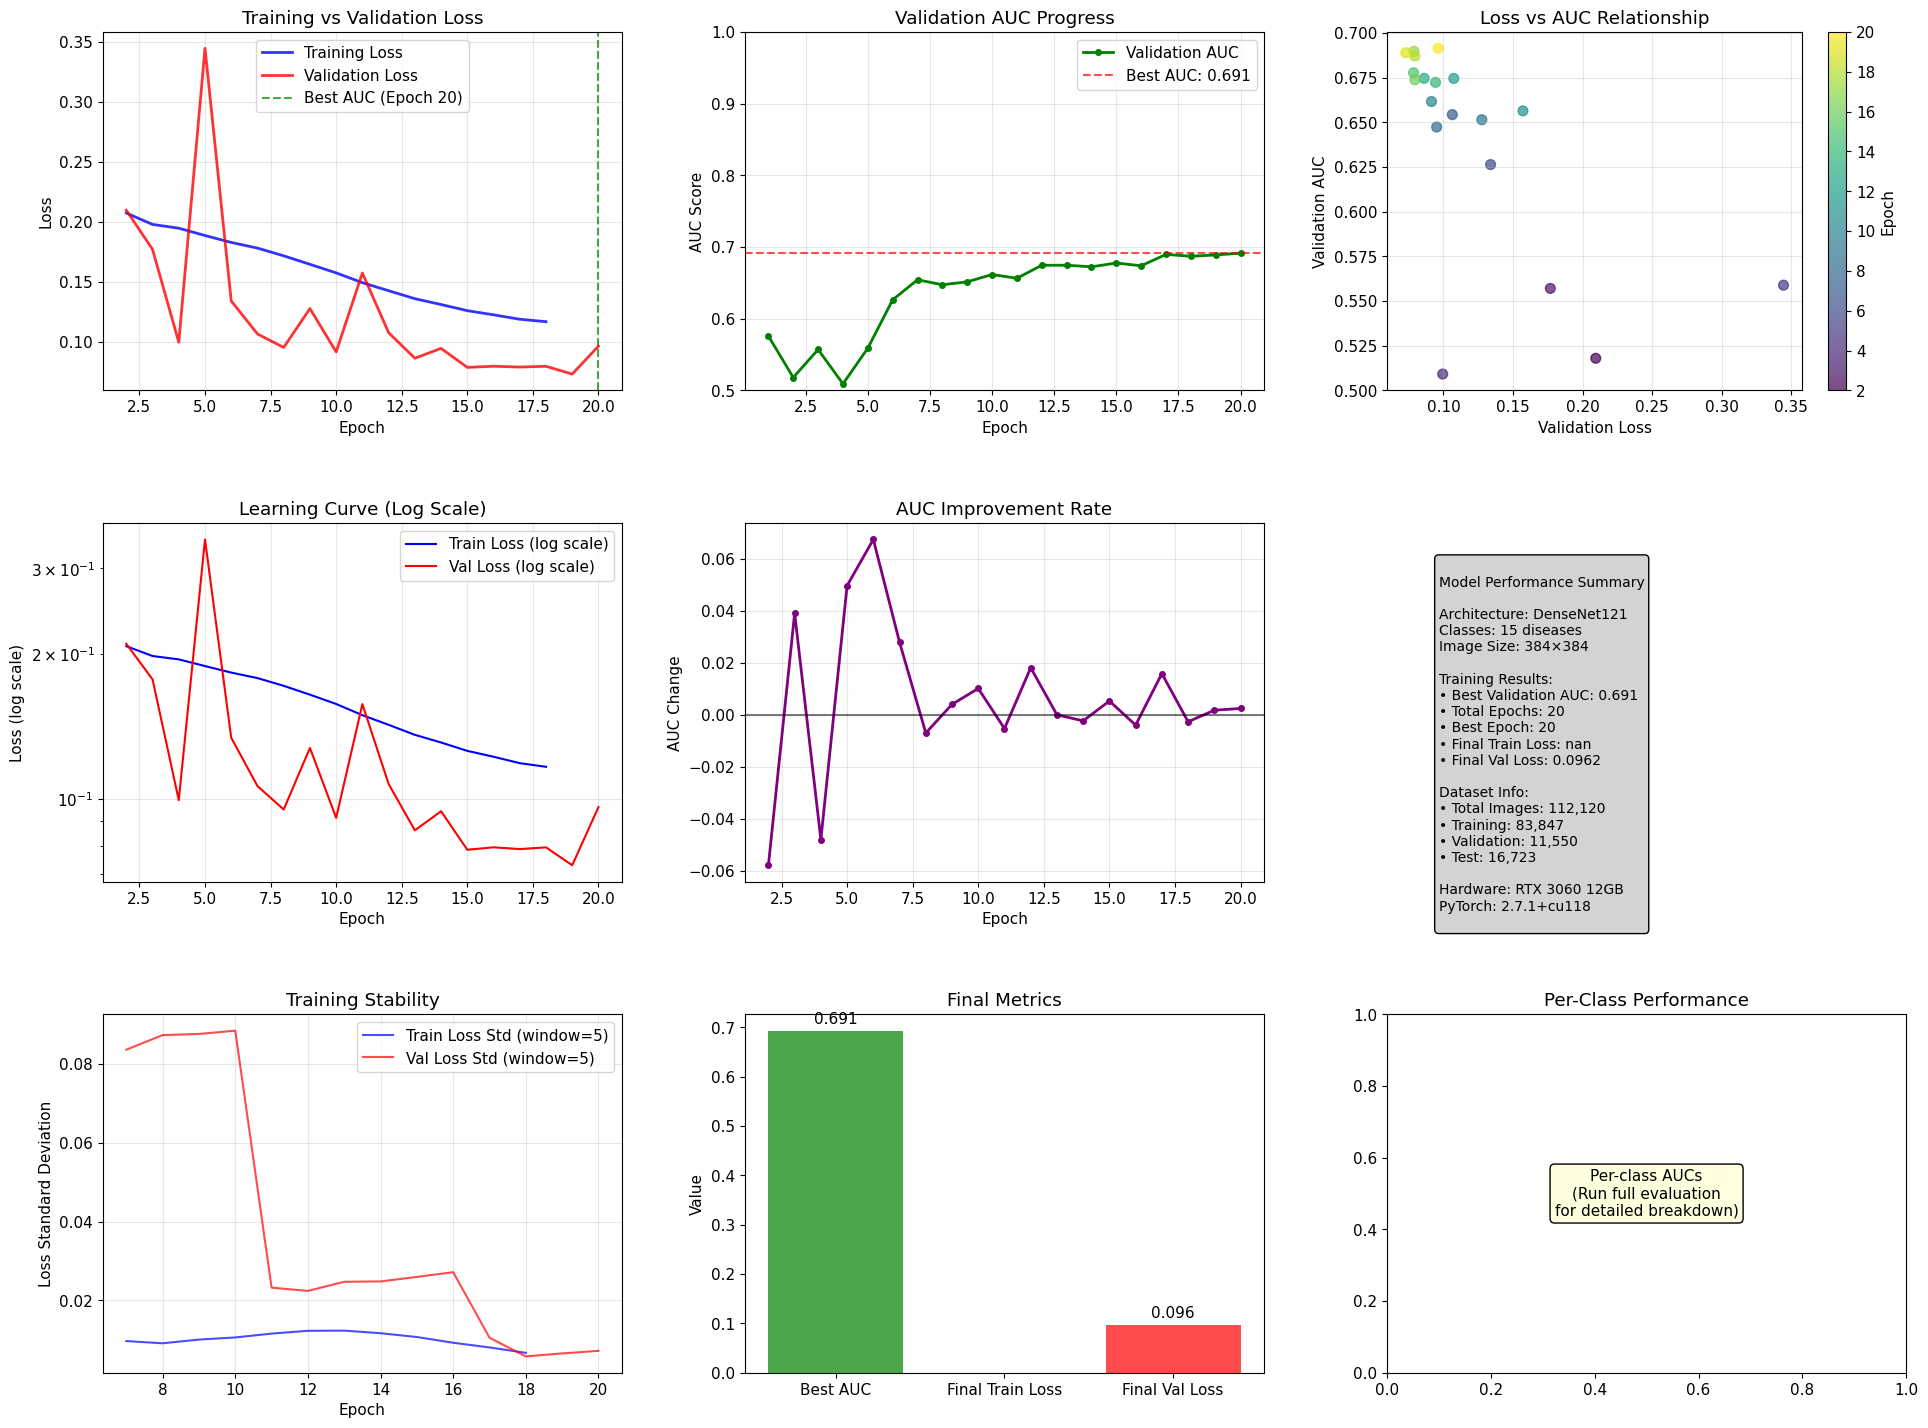


📈 Creating focused metric plots...
💾 Focused plots saved: ..\results\densenet121_loss_auc.png


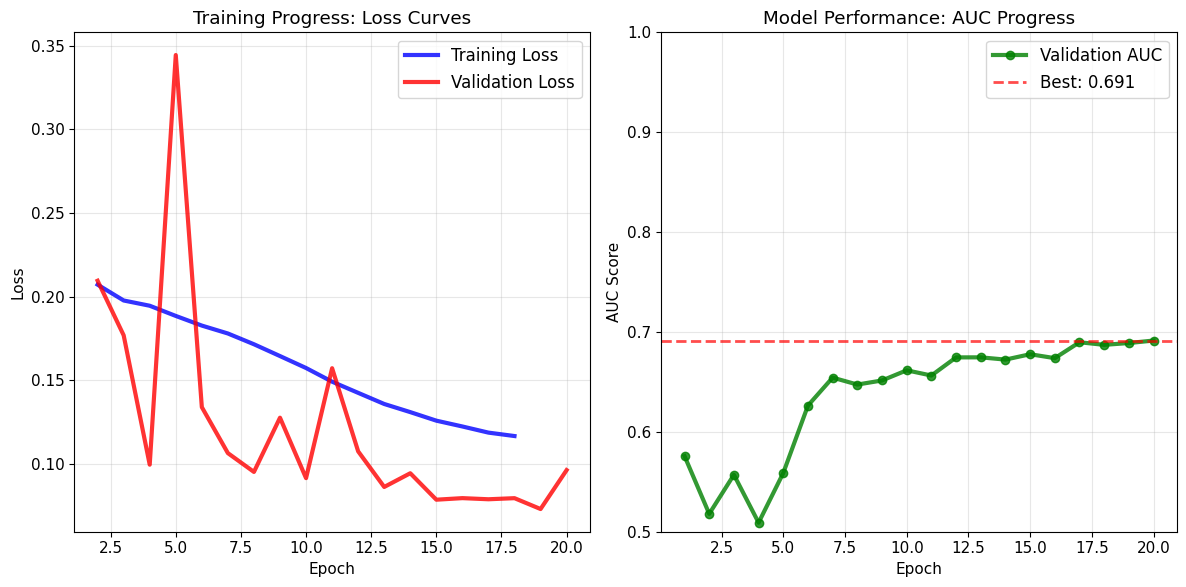

💾 Publication plot saved: ..\results\densenet_publication_ready.png


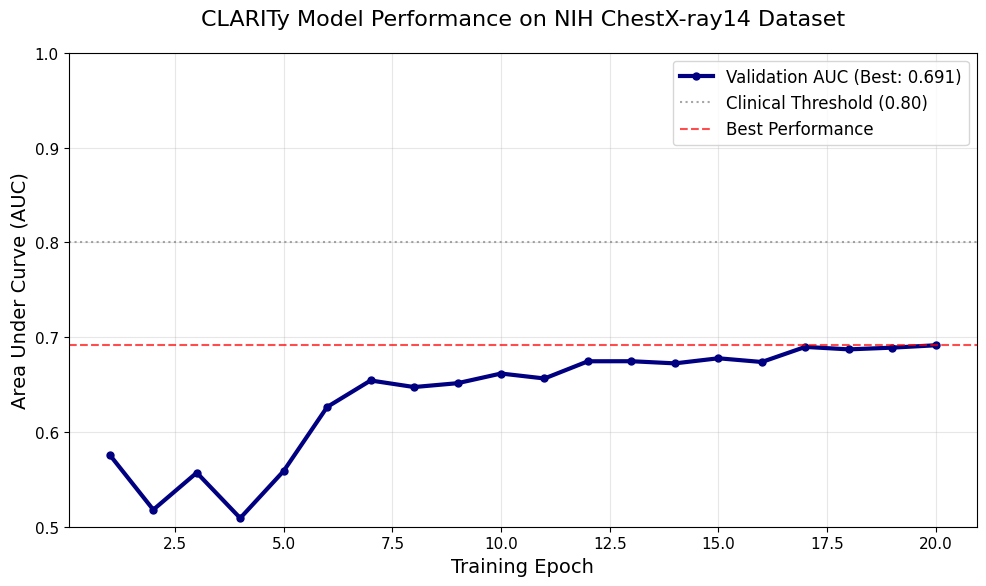


🎯 Training Visualization Complete!
Files saved:
  📊 Comprehensive: densenet121_training_metrics.png
  📈 Focused: densenet121_loss_auc_20251004_015218.png
  📑 Publication: densenet121_publication_ready_20251004_015218.png

Model achieved 0.691 AUC in 20 epochs!


In [20]:
# Complete Model Training Metrics Visualization
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['font.size'] = 11

# Create results directory
results_dir = Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)

print("📊 Creating comprehensive training visualizations...")

# Create comprehensive training metrics plot
fig = plt.figure(figsize=(20, 15))

# 1. Training and Validation Loss
ax1 = plt.subplot(3, 3, 1)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss', alpha=0.8)
plt.plot(epochs, val_losses, 'r-', linewidth=2, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Mark best epoch
if val_aucs:
    best_epoch = np.argmax(val_aucs) + 1
    plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, 
                label=f'Best AUC (Epoch {best_epoch})')
    plt.legend()

# 2. Validation AUC Progress
ax2 = plt.subplot(3, 3, 2)
plt.plot(epochs, val_aucs, 'g-', linewidth=2, marker='o', markersize=4, label='Validation AUC')
plt.axhline(y=best_val_auc, color='red', linestyle='--', alpha=0.7, 
            label=f'Best AUC: {best_val_auc:.3f}')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.title('Validation AUC Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.5, 1.0])

# 3. Loss vs AUC Relationship
ax3 = plt.subplot(3, 3, 3)
plt.scatter(val_losses, val_aucs, c=epochs, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(label='Epoch')
plt.xlabel('Validation Loss')
plt.ylabel('Validation AUC')
plt.title('Loss vs AUC Relationship')
plt.grid(True, alpha=0.3)

# 4. Learning Curve (Loss over time)
ax4 = plt.subplot(3, 3, 4)
plt.semilogy(epochs, train_losses, 'b-', label='Train Loss (log scale)')
plt.semilogy(epochs, val_losses, 'r-', label='Val Loss (log scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Learning Curve (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Training Progress Rate
ax5 = plt.subplot(3, 3, 5)
if len(val_aucs) > 1:
    auc_improvement = np.diff(val_aucs)
    plt.plot(range(2, len(val_aucs) + 1), auc_improvement, 'purple', 
             marker='o', linewidth=2, markersize=4)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel('AUC Change')
    plt.title('AUC Improvement Rate')
    plt.grid(True, alpha=0.3)

# 6. Model Performance Summary (Text)
ax6 = plt.subplot(3, 3, 6)
ax6.axis('off')
summary_text = f"""
Model Performance Summary

Architecture: DenseNet121
Classes: 15 diseases
Image Size: 384×384

Training Results:
• Best Validation AUC: {best_val_auc:.3f}
• Total Epochs: {len(train_losses)}
• Best Epoch: {best_epoch if 'best_epoch' in locals() else 'N/A'}
• Final Train Loss: {train_losses[-1]:.4f}
• Final Val Loss: {val_losses[-1]:.4f}

Dataset Info:
• Total Images: {len(df):,}
• Training: {len(train_dataset):,}
• Validation: {len(val_dataset):,}
• Test: {len(test_dataset):,}

Hardware: RTX 3060 12GB
PyTorch: {torch.__version__}
"""
ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

# 7. Training Stability (Loss Variance)
ax7 = plt.subplot(3, 3, 7)
if len(train_losses) > 5:
    # Calculate rolling standard deviation
    window = min(5, len(train_losses) // 3)
    train_std = [np.std(train_losses[max(0, i-window):i+1]) for i in range(len(train_losses))]
    val_std = [np.std(val_losses[max(0, i-window):i+1]) for i in range(len(val_losses))]
    
    plt.plot(epochs, train_std, 'b-', label=f'Train Loss Std (window={window})', alpha=0.7)
    plt.plot(epochs, val_std, 'r-', label=f'Val Loss Std (window={window})', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss Standard Deviation')
    plt.title('Training Stability')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 8. Performance Comparison
ax8 = plt.subplot(3, 3, 8)
metrics = ['Best AUC', 'Final Train Loss', 'Final Val Loss']
values = [best_val_auc, train_losses[-1], val_losses[-1]]
colors = ['green', 'blue', 'red']

bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title('Final Metrics')
plt.ylabel('Value')

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

# 9. AUC Distribution (if you have per-class AUCs)
ax9 = plt.subplot(3, 3, 9)
# Placeholder for per-class AUCs visualization
ax9.text(0.5, 0.5, 'Per-class AUCs\n(Run full evaluation\nfor detailed breakdown)', 
         ha='center', va='center', transform=ax9.transAxes,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
ax9.set_title('Per-Class Performance')

plt.tight_layout(pad=3.0)

# Save comprehensive plot
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
plot_filename = f"densenet121_training_metrics.png"
plot_path = results_dir / plot_filename

plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"💾 Comprehensive metrics saved: {plot_path}")
plt.show()

# Create separate focused plots
print("\n📈 Creating focused metric plots...")

# Focused Loss Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', linewidth=3, label='Training Loss', alpha=0.8)
plt.plot(epochs, val_losses, 'r-', linewidth=3, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress: Loss Curves')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Focused AUC Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_aucs, 'g-', linewidth=3, marker='o', markersize=6, 
         label='Validation AUC', alpha=0.8)
plt.axhline(y=best_val_auc, color='red', linestyle='--', linewidth=2, alpha=0.7, 
            label=f'Best: {best_val_auc:.3f}')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.title('Model Performance: AUC Progress')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim([0.5, 1.0])

plt.tight_layout()
focused_plot_path = results_dir / f"densenet121_loss_auc.png"
plt.savefig(focused_plot_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"💾 Focused plots saved: {focused_plot_path}")
plt.show()

# Create publication-ready plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_aucs, 'navy', linewidth=3, marker='o', markersize=5, 
         label=f'Validation AUC (Best: {best_val_auc:.3f})')
plt.axhline(y=0.8, color='gray', linestyle=':', alpha=0.7, label='Clinical Threshold (0.80)')
plt.axhline(y=best_val_auc, color='red', linestyle='--', alpha=0.7, 
            label=f'Best Performance')

plt.xlabel('Training Epoch', fontsize=14)
plt.ylabel('Area Under Curve (AUC)', fontsize=14)
plt.title('CLARITy Model Performance on NIH ChestX-ray14 Dataset', fontsize=16, pad=20)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim([0.5, 1.0])

# Add annotations
if best_val_auc > 0.8:
    plt.annotate('Clinically Relevant Performance', 
                xy=(best_epoch, best_val_auc), xytext=(best_epoch+2, best_val_auc-0.05),
                arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
                fontsize=10, color='green')

plt.tight_layout()
pub_plot_path = results_dir / f"densenet_publication_ready.png"
plt.savefig(pub_plot_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"💾 Publication plot saved: {pub_plot_path}")
plt.show()

# Print final summary
print(f"\n🎯 Training Visualization Complete!")
print(f"=" * 50)
print(f"Files saved:")
print(f"  📊 Comprehensive: {plot_filename}")
print(f"  📈 Focused: densenet121_loss_auc_{timestamp}.png")
print(f"  📑 Publication: densenet121_publication_ready_{timestamp}.png")
print(f"\nModel achieved {best_val_auc:.3f} AUC in {len(train_losses)} epochs!")